#**Function Approximation with State Aggregation - Deforestation**



In this notebook we will solve a simple deforestation model in the view of a
firm which wants to maximize its profits.


![Photo by Pok Rie from Pexels](https://drive.google.com/uc?id=1ZyDlOuX3dxp6QoWJUbUH0HULPG8qIpRd) (Photo by Pok Rie - Pexels)

A firm owns woodland with 100 units of wood. 
The firm must decide how much wood to deforest each year. 
The firm can sell the wood at price $p$ per unit. 
The total cost of extracting $a$ units of wood in any year, given that the area
contains $s$ units of wood at the beginning of the year is $c(s, a)$.

The market price $p = 1$, cost of extraction is $c(s, a) = x^2/(1+s)$, and
annual discount factor $\gamma = 0.9$.





# **Model**


The units of wood $s$ is a discrete state variable:
- $s \in \{0, 1, 2, \dots, 100\}$


The action variable $a$ is the amount of deforested wood:
- $a \in \{0, 1, 2, \dots, 24\}$

The state transition function is:
- $t(s, a) = s - a$

The reward function is:
- $r(s, a) = p\cdot a - c(s, a)$

# Environment

We are using Open AI Gym to create our environments. 

The Gym interface of an environment is described in
[https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).

Next you will implement the deforestation model with the Open AI Gym framework,
but first import all the necessary libraries for this notebook.

In [2]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

The structure of the gym environment is given. You have to implement the
state transistion only.

In [16]:
class DeforestationEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(DeforestationEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        n_actions = 25
        self.action_space = spaces.Discrete(n_actions)

        self.initial_wood = 100
        self.observation_space = spaces.Discrete(self.initial_wood+1)

        # Set the price
        self.price = 1

        # Create random number generator
        self.rng = default_rng()

        # Create state attribute
        self.state = None
        
        
    def step(self, action):
        """State transition of the model.

        Implements the model of the environment.

        Args:
            action (int): Action the agent took

        Returns:
            next_state (int): The next state the environment emits
            reward (int): The reward the environment emits
            done (bool): True if current state is terminal
            info (dict): Infos that can be used for debugging
        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        assert action <= self.state, "%r is to much extraction, current state: %r" % (action, self.state)

        # Calculate the reward
        reward = self.price*action - action**2/(1+self.state)

        # Calculate the next state
        self.state -= action

        # Check if we reached terminal state
        done = self.state == 0

        info = {}

        return self.state, reward, done, info


    def reset(self):
        """Resets the environment.

        Initializes the state.

        Returns:
            state (int): Initial state

        """
        self.state = self.initial_wood
                      
        return self.state

    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

In [17]:
def get_state_feature(n_states_in_group, n_groups, state):
    """Given state, return the feature of that state.

    Terminal state 0 is not included.

    Args:
        n_states_in_group (int): number of states in each group
        n_groups (int): number of groups
        state (int): current state

    Returns:
        one_hot_vector (numpy.ndarray): one hot representation of state
    """

    # Create one_hot_vector with size of the num_groups, according to state
    # For simplicity, assume n_states is always perfectly divisible by n_groups
    # Note that states start from index 1, not 0!

    # Example:
    # If n_states = 100, n_states_in_group = 20, n_groups = 5,
    # one_hot_vector would be of size 5.
    # For states 1~20, one_hot_vector would be: [1, 0, 0, 0, 0]

    index = (state - 1) // n_states_in_group

    one_hot_vector = np.zeros(n_groups)
    one_hot_vector[index] = 1

    return one_hot_vector



In [18]:
class RandomAgent:
    def __init__(self, agent_info):
        """Initialize Agent.

        Args:
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                n_states (int): Number of states.
                n_groups (int): Number of groups.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.n_states = agent_info["n_states"]
        self.n_groups = agent_info["n_groups"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        # Pre-compute all observable features
        n_states_in_group = int((self.n_states-1) / self.n_groups)

        self.all_state_features = np.array(
            [get_state_feature(n_states_in_group, self.n_groups, state)
             for state in range(1, self.n_states)]
        )

        # Create random number generator
        self.rng = default_rng()

        # Create a dict for action-value estimates and initialize it to zero.
        self.weights = np.zeros(self.n_groups)

        # Attributes to save previous actions and states
        self.previous_action = None
        self.previous_state = None


    def step(self, reward, state, done):
        """A step taken by the agent.

        Args:
            reward (int): Reward from the environment.
            state (int): State from the environment.
            done (bool): True if state is terminal.

        Returns:
            action (int): Action the agent takes.
        """

        self.step_size *= 0.99999

        # Choose action using epsilon greedy policy
        action = self.select_action(state)

        # Determine the target
        if done:
            target = reward
        else:
            current_state_feature = self.all_state_features[state-1]
            target = reward + self.discount * self.weights@current_state_feature.T

        # Determine the TD error
        last_state_feature = self.all_state_features[self.previous_state-1]
        td_error = target - self.weights@last_state_feature

        # Update the weights
        self.weights += self.step_size * td_error * last_state_feature

        # Save current state and action
        self.previous_state = state
        self.previous_action = action

        return action

        
    def select_action(self, state):
        """Select action using epsilon greedy policy.

        Args:
            state (int): Current state.

        Returns:
            action (int): Action the agent takes.
        """
        
        max_possible_action = np.minimum(state, self.n_actions-1)

        action = self.rng.integers(max_possible_action, endpoint=True)

        return action


    def start(self, state):
        """Selects action in inital state

        Args:
            state (int): initial state
        
        Returns:
            action (int): initial action
        """

        action = self.select_action(state)

        self.previous_state = state
        self.previous_action = action

        return action





---


**Let's test our environment**


---


You can find the basic structure to simulate the environment in the
[Open AI documentation](https://gym.openai.com/docs/).


In [26]:
# Create environment
env = DeforestationEnv()

# Set parameters
n_actions = env.action_space.n
n_states = env.observation_space.n
n_groups = 10
step_size = 0.1
discount = 0.9


agent_info = {"n_actions": n_actions,
              "n_states": n_states,
              "n_groups": n_groups,
              "step_size": step_size,
              "discount": discount}

# Create agent
agent = RandomAgent(agent_info)


In [27]:
# Set number of episodes
n_episodes = 10000

# Simulate many episodes
for i in range(n_episodes):
    # Get the initial state
    state = env.reset()

    # Get the initial action
    action = agent.start(state)

    # Simulate the agent environment interaction
    done = False
    while not done:
        state, reward, done, _ = env.step(action)
        action = agent.step(reward, state, done)

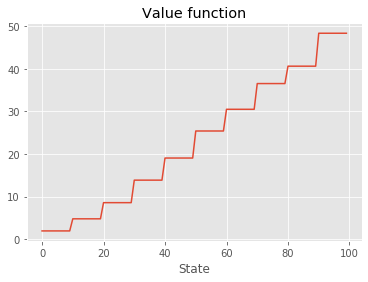

In [28]:
# Calculate the value function
value = agent.weights@agent.all_state_features.T

# Plot the value function
fig, ax = plt.subplots()

ax.set_title('Value function')
ax.set_xlabel('State')
ax.plot(value);